# Solving Blackjack with DQN
This notebook trains a DQN agent to solve the Blackjack environment using [Stable Baselines3](https://stable-baselines3.readthedocs.io/en/master/).


More details about the game here [Blackjack](https://gymnasium.farama.org/environments/toy_text/blackjack/).
Check editing


In [ ]:
%%capture
!pip install gymnasium
!pip install stable-baselines3

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor

from gymnasium.spaces import Box
from gymnasium.wrappers import TransformObservation

In [ ]:
from stable_baselines3.common.callbacks import BaseCallback
from IPython.display import clear_output
from stable_baselines3.common.evaluation import evaluate_policy

def moving_average(data, window_size=200):
    if len(data) < window_size:
        return data
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

class LiveEvalCallback(BaseCallback):
    def __init__(self, env, n_eval_episodes=20, save_path="best_model", verbose=0):
        super().__init__(verbose)
        self.eval_env = env
        self.eval_freq = 1
        self.n_eval_episodes = n_eval_episodes
        self.save_path = save_path
        self.best_mean_reward = -float("inf")
        self.eval_rewards = []
        self.eval_timesteps = []
        self.plot_freq = 500

    def _on_step(self) -> bool:
        if self.num_timesteps % self.eval_freq == 0:
            mean_reward, _ = evaluate_policy(
                self.model, self.eval_env,
                n_eval_episodes=self.n_eval_episodes,
                render=False,
                deterministic=True
            )
            self.eval_rewards.append(mean_reward)
            self.eval_timesteps.append(self.num_timesteps)

            # Save best model
            if mean_reward > self.best_mean_reward:
                self.best_mean_reward = mean_reward
                self.model.save(self.save_path)

            # Live plot
            if self.num_timesteps % self.plot_freq == 0:
                clear_output(wait=True)
                plt.figure(figsize=(8, 4))
                plt.clf()

                 # Compute moving average
                smoothed_rewards = moving_average(self.eval_rewards, window_size=200)

                plt.plot(smoothed_rewards, label="Moving Avg Reward")
                plt.xlabel("Timesteps")
                plt.ylabel("Avg Reward")
                plt.title("Evaluation Reward (Moving Avg)")

                plt.grid(True)
                plt.legend()
                plt.show()

        return True

In [ ]:
def evaluate_custom_policy(policy_fn, env, n_episodes=10000):
    total_rewards = []
    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            obs_np = np.array([obs[0], obs[1], int(obs[2])], dtype=np.float32)
            action = policy_fn(obs_np)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
        total_rewards.append(episode_reward)
    return np.mean(total_rewards), np.std(total_rewards)

## Environment Setup and Preprocessing
We convert the observation (a tuple of integers) into a NumPy array suitable for SB3.

In [ ]:
# Blackjack environment returns a tuple: (player_sum, dealer_card, usable_ace)
# We convert it into a flat NumPy array to work with SB3
# blackjack-v1 observation is a tuple: (player_sum, dealer_card, usable_ace)
def flatten_obs(obs):
    return np.array([obs[0], obs[1], int(obs[2])], dtype=np.float32)


train_env = gym.make('Blackjack-v1', sab=True)
# Define the observation space of the transformed observations
observation_space = Box(low=np.array([1, 1, 0]), high=np.array([32, 11, 1]), dtype=np.float32)
# Now pass the observation_space to TransformObservation
train_env = TransformObservation(train_env, flatten_obs, observation_space)

In [ ]:
# Separate evaluation env
eval_env = gym.make('Blackjack-v1', sab=True)
eval_env = Monitor(eval_env)
eval_env = TransformObservation(eval_env, flatten_obs, observation_space)
eval_env = Monitor(eval_env)

# Use deterministic actions for evaluation
eval_callback = LiveEvalCallback(eval_env, verbose=0)

## Implementing Heurisitic Agents

Implement a heuristic policy for playing Blackjack.

In [ ]:
def my_heuristic_policy(obs):
    player_sum, dealer_card, usable_ace = obs
    ##################################################
    ##### Implement your code here #####
    if player_sum <= 11:
      player_action = 1

    elif player_sum >= 17:
      player_action = 0

    elif player_sum >= 12 and player_sum <= 16 and dealer_card <= 6:
      player_action = 0

    else:
      player_action = 1;


    # player_action = train_env.action_space.sample()
    ##################################################
    return player_action

In [ ]:
# Return a random action
def random_policy(obs):
    return train_env.action_space.sample()

My Heuristic: Mean Reward = -0.07 ± 0.95
Random (random action): Mean Reward = -0.40 ± 0.89


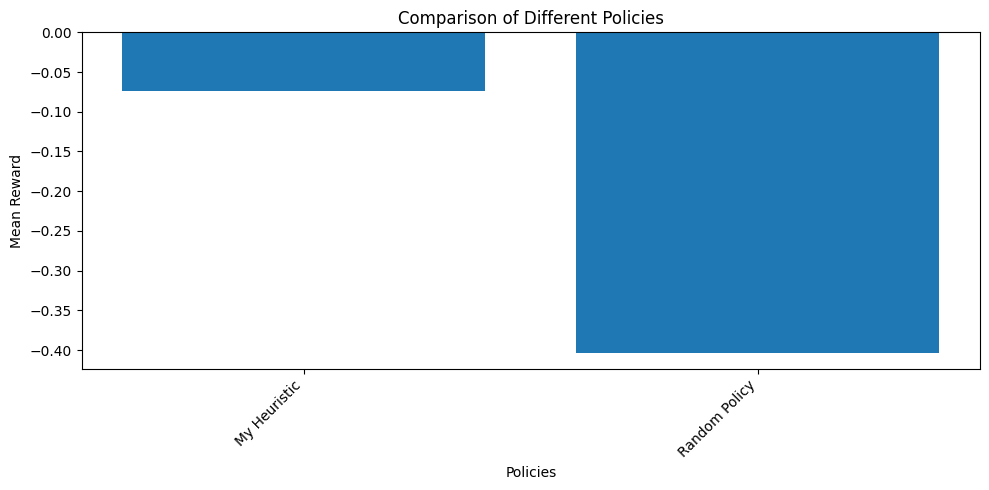

In [ ]:
# Evaluate heuristic and random policies
my_heuristic_mean, my_heuristic_std = evaluate_custom_policy(my_heuristic_policy, train_env)
random_mean, random_std = evaluate_custom_policy(random_policy, train_env)

print(f"My Heuristic: Mean Reward = {my_heuristic_mean:.2f} ± {my_heuristic_std:.2f}")
print(f"Random (random action): Mean Reward = {random_mean:.2f} ± {random_std:.2f}")

policies = {
    'My Heuristic': my_heuristic_mean,
    'Random Policy': random_mean
}

plt.figure(figsize=(10, 5))
plt.bar(policies.keys(), policies.values())
plt.xlabel("Policies")
plt.ylabel("Mean Reward")
plt.title("Comparison of Different Policies")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## Training the DQN Agent

In [ ]:
# Train with callback
model = DQN('MlpPolicy', train_env, verbose=0,
            learning_rate=0.01,
            buffer_size=100,
            exploration_fraction=0.1)

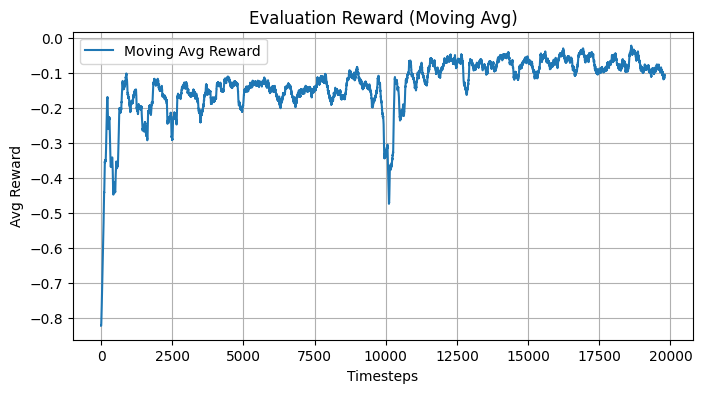

In [ ]:
# Learn
model.learn(total_timesteps=10000, callback=eval_callback)

In [ ]:
best_model = DQN.load("best_model")

## Experimenting with Hyperparameters

Hyperparameters significantly affect the learning performance of reinforcement learning agents.

Let us compare outcomes across different configurations.

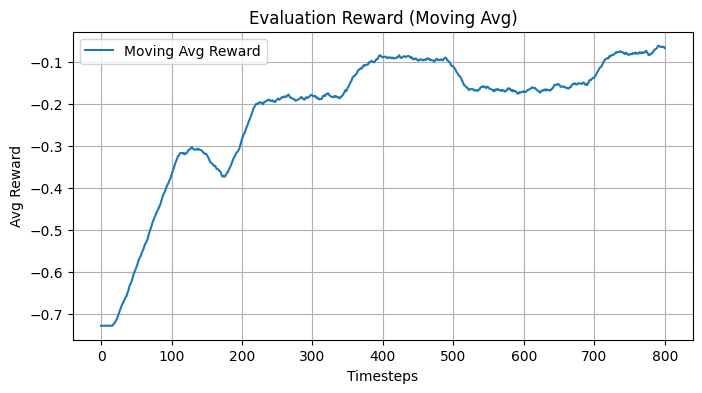

In [ ]:
# Train with callback
model = DQN('MlpPolicy', train_env, verbose=0,
            learning_rate=.001,
            buffer_size=50000,
            exploration_fraction=0.1)
# Learn
eval_callback = LiveEvalCallback(eval_env, verbose=0)
model.learn(total_timesteps=1000, callback=eval_callback)
best_model = DQN.load("best_model")


## Comparing with Heuristic Policies
We’ll compare the trained DQN agent with a simple heuristic: Stick if player sum >= 19, else hit.

In [ ]:
# - Stick if sum ≥ 19, else hit/
def simple_heuristic_policy(obs):
    player_sum, dealer_card, usable_ace = obs
    return 0 if player_sum >= 10 else 1  # 0 = stick, 1 = hit

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


DQN Agent:      Mean Reward = 0.30 ± 0.90
My Heuristic: Mean Reward = -0.07 ± 0.95
Simple Heuristic : Mean Reward = -0.16 ± 0.96
Random (random action): Mean Reward = -0.40 ± 0.89


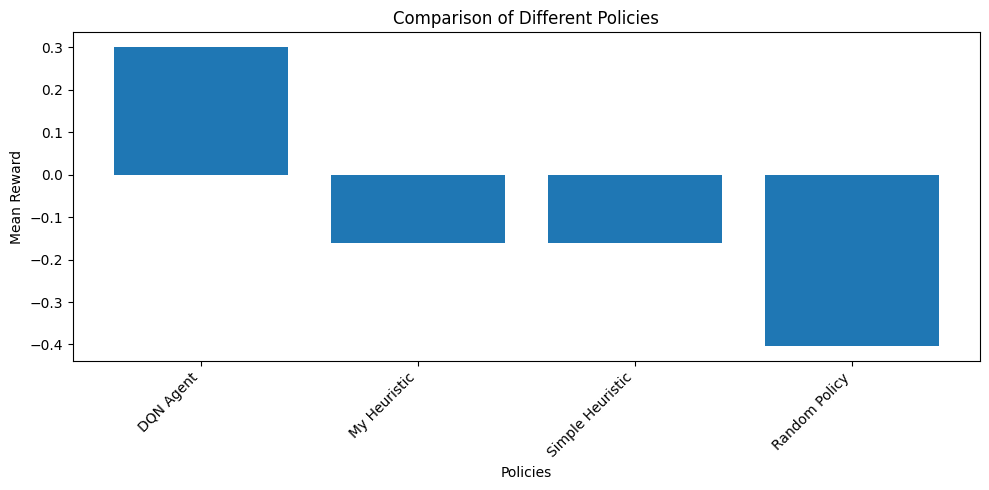

In [ ]:
# Evaluate all policies
dqn_mean, dqn_std = evaluate_policy(model, train_env)
simple_heuristic_mean, simple_heuristic_std = evaluate_custom_policy(simple_heuristic_policy, train_env)

print(f"DQN Agent:      Mean Reward = {dqn_mean:.2f} ± {dqn_std:.2f}")
print(f"My Heuristic: Mean Reward = {my_heuristic_mean:.2f} ± {my_heuristic_std:.2f}")
print(f"Simple Heuristic : Mean Reward = {simple_heuristic_mean:.2f} ± {simple_heuristic_std:.2f}")
print(f"Random (random action): Mean Reward = {random_mean:.2f} ± {random_std:.2f}")

policies = {
    'DQN Agent': dqn_mean,
    'My Heuristic': simple_heuristic_mean,
    'Simple Heuristic': simple_heuristic_mean,
    'Random Policy': random_mean
}

plt.figure(figsize=(10, 5))
plt.bar(policies.keys(), policies.values())
plt.xlabel("Policies")
plt.ylabel("Mean Reward")
plt.title("Comparison of Different Policies")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()
